# Preprocessing and augmentation
In this notebook we'll look at different ways of augmenting our data - e.g. adding background noise from the "silence" files provided by the Google Brain team and making small alterations to the .wav files themselves. The latter is similar to adding a small rotation to an image in image preprocessing. 

The goal is to get a more diverse / larger training set. We've already experimented with turning our .wav files into images (spectrograms and chromagrams) in the previous notebook and that is also a form of preprocessing. 

In the next notebook we will use the preprocessing & augmentation methods outlined here to create new sample subsets of our data and we'll test simple models on them, in order to figure out which types of preprocessing are most promising.

In [1]:
# first make sure we're in the parent dictory of our data/sample folders.
!pwd

/c/Users/mateusz/Documents/Mateusz/Career/Machine Learning & AI/tensorflow_speech_recognition/tensorflow_speech_recognition


## Import
We'll need a couple of additional libraries so let's import them.

In [24]:
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings


from pydub import AudioSegment

# utils
from importlib import reload
import utils; reload(utils)

# audio mixing and augmentation functions from utils.py
from utils import mix_audio, augment_with_white_noise

# graphing functions from utils.py
from utils import get_wav_info, display_audio, graph_waveform, graph_multiple_waveforms
from utils import graph_spectrogram, graph_multiple_spectrograms, graph_mel_spectrogram
from utils import graph_waveform_from_data

In [25]:
# filter out warnings
warnings.filterwarnings('ignore') 

## Add background noise
The authors of the competition suggest using the provided "silence" category memebers as background noise - we can mix it in with our other .wav files to produce more "realistic" samples. 

We have plenty to choose from - white & pink noise samples, the background sounds of an exercise bike, dishes being done as well as the sound of water running from a tap.

We'll be using the pydub library as it makes this kind of audio mixing very intuitive.

In [4]:
# define paths
path_to_sample = "data\\sample"
path_to_stop = os.path.join(path_to_sample, "train\\stop\\2da58b32_nohash_2.wav")
path_to_background = os.path.join(path_to_sample, "train\\silence\\pink_noise_45.wav")

In [5]:
# we will also want a separate temporary directory to store our mixed files
path_to_tmp = os.path.join(path_to_sample, "tmp")
!mkdir $path_to_tmp

We will try to mix a pink noise background file with an example of someone saying "stop". Here's how these files originally sound:

In [6]:
display_audio(path_to_stop)

In [7]:
display_audio(path_to_background)

We can immediately hear that the "stop" recording has much lower volume than the "silence" one, rather ironically. If we mix them together without adjusting the volume we'll get a sound like this one:

In [8]:
# let's mix the two audio files together
sound1 = AudioSegment.from_wav(path_to_stop)
sound2 = AudioSegment.from_wav(path_to_background)

# mix sound2 with sound1, starting at 0ms into sound1)
output = sound1.overlay(sound2, position=0)

# save the result to data\sample\tmp
path_to_mixed = os.path.join(path_to_tmp, "stop_plus_pink_noise.wav")
output.export(path_to_mixed, format="wav")

<_io.BufferedRandom name='data\\sample\\tmp\\stop_plus_pink_noise.wav'>

In [9]:
display_audio(path_to_mixed)

The pink noise is too loud for us to even make out the person saying "stop". Even if we could get a model that would pick up the "stop" that would be pointless - we don't want a model that can overhear someone in the background saying a command.

Thanks to pydub adjusting the volume is very simple.

In [10]:
# grab the two files again
sound1 = AudioSegment.from_wav(path_to_stop)
sound2 = AudioSegment.from_wav(path_to_background)

# we need to make sound 2 more quiet
# reduce volume by 20 dB
sound2_20_db_quieter = sound2 - 20

# mix sound2 with sound1, starting at 0ms into sound1)
output = sound1.overlay(sound2_20_db_quieter, position=0)

# save the result
path_to_mixed_quieter = os.path.join(path_to_tmp, "stop_plus_pink_noise_quieter.wav")
output.export(path_to_mixed_quieter, format="wav")

<_io.BufferedRandom name='data\\sample\\tmp\\stop_plus_pink_noise_quieter.wav'>

In [11]:
display_audio(path_to_mixed_quieter)

That's much better. We can use other background noises provided by Kaggle in a similar fashion, being careful to adjust the volume. In fact we should have a function that takes 2 files and mixes them together, adjusting the volume if necessary. Luckily we have one that does just that in the utils.

In [12]:
path_to_mixed_via_function = mix_audio(path_to_stop, path_to_background, path_to_mixed_quieter, volume_adjustment=20)

In [13]:
display_audio(path_to_mixed_via_function)

We now have a way to programatically mix the provided background noise with our actual samples, adjusting the volume.

We can also look at the waveforms of our files.

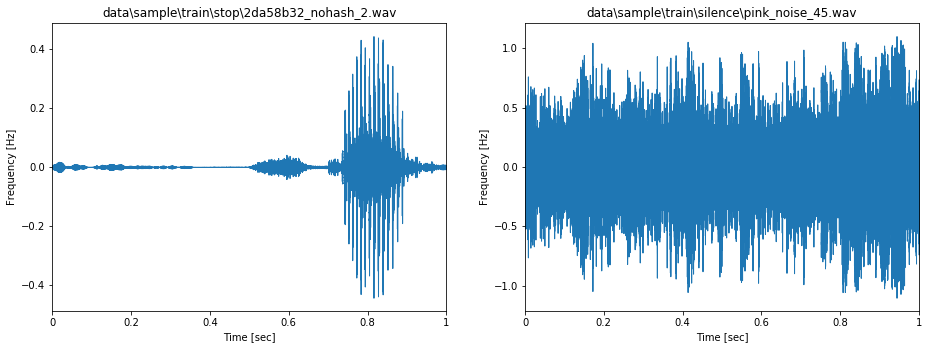

In [14]:
# show our original "stop" and pink noise waveforms:
graph_multiple_waveforms([path_to_stop, path_to_background])

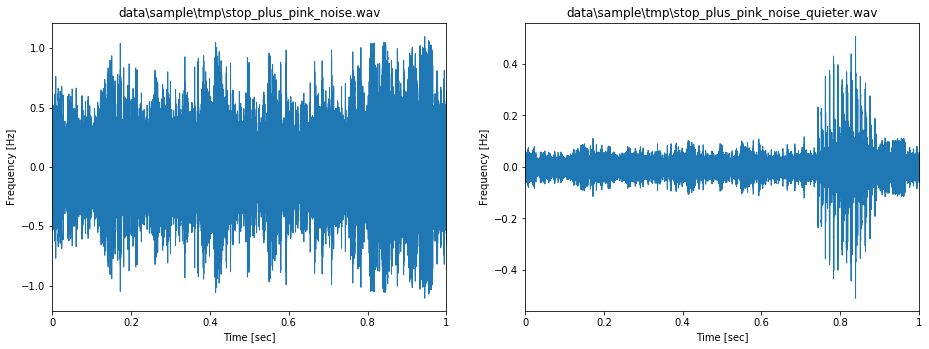

In [15]:
# compare the 2 versions of the mixed files, one without and one with the volume adjustment
graph_multiple_waveforms([path_to_mixed, path_to_mixed_quieter])

## Data augmentation
Now let's directly manipulate the data from the audio files to slightly alter them.

### White noise
It's relatively easy to add white noise to a file - we just create a random array of the same length as our original audio file's content and add the two together, keeping the same sampling rate.

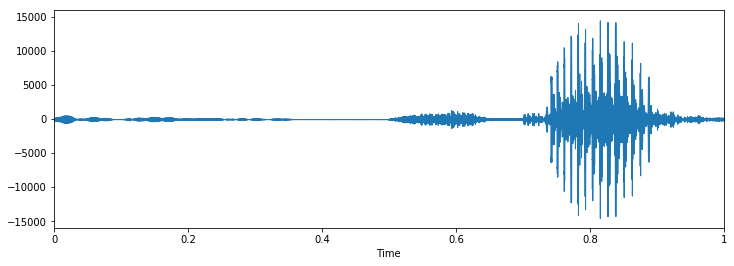

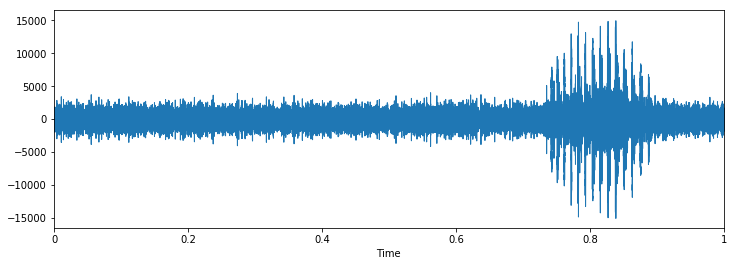

In [16]:
# first get the sampling rate and content of a .wav file
sr, data = get_wav_info(path_to_stop)

# add random white noise
wn = np.random.randn(len(data))
data_wn = data + 1000*wn

graph_waveform_from_data(data, sampling_rate=sr)
graph_waveform_from_data(data_wn, sampling_rate=sr)

We would prefer to use a function for this so let's take advantage of our utils.py again. We can specify the amount of white noise we wish to add, judging by the cell above a white noise multiplication factor of 1000 works well and thus is used as default.

In [17]:
path_to_added_white_noise = os.path.join(path_to_tmp, "stop_with_added_white_noise.wav")
augment_with_white_noise(path_to_stop, path_to_added_white_noise, wn_factor=1000)

'data\\sample\\tmp\\stop_with_added_white_noise.wav'

In [19]:
get_wav_info(path_to_stop)

(16000, array([135, 155, 177, ..., 231, 217, 185], dtype=int16))

In [18]:
get_wav_info(path_to_added_white_noise)

(16000, array([  641,  1605,  -713, ..., -1356,   664,   432], dtype=int16))

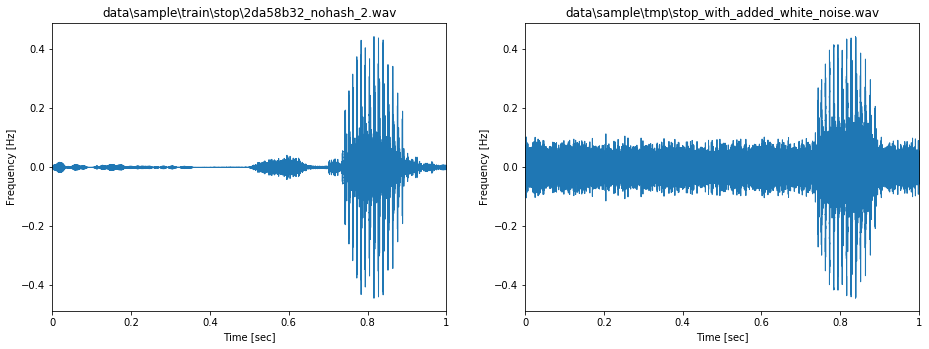

In [20]:
graph_multiple_waveforms([path_to_stop, path_to_added_white_noise])

Looks good, let's listen to the files though:

In [21]:
display_audio(path_to_stop)

In [22]:
display_audio(path_to_added_white_noise)

The word "stop" is a bit more difficult to distinguish in our new version with the randomly generated white noise and that's the reason we kept our wn_factor customizable - if we decrease the amount of white noise we can get a better sample.

In [23]:
# define a new path
path_to_added_white_noise_adjusted = os.path.join(path_to_tmp, "stop_with_added_white_noise_adjusted.wav")

# let's decrease the amount of whitenoise via the wn_factor parameter
augment_with_white_noise(path_to_stop, path_to_added_white_noise_adjusted, wn_factor=200)

display_audio(path_to_added_white_noise_adjusted)

## Shifting
Add shifting the sound as described here:
https://www.kaggle.com/CVxTz/audio-data-augmentation

## Stretching
Add stretching the sound as described here:
https://www.kaggle.com/CVxTz/audio-data-augmentation

### NEXT
    1) Add the two sections listed above 
    2) and then use the next notebook to generate new sample_X folders, each created by different mixes of preprocessing and augmentation techniques and test simple linear model / simple CNN on them.
    3) decide on the best mix of preprocesing based on sample experiments and create a notebook for preprocessing the entire set

### Clean up
Finally let's clean up our tmp directory.

In [17]:
# remove the temporary directory and all its contents
!rm -r $path_to_tmp